# What do I want?
In `classifier_comparison` I train and compare classifiers.  Furthermore I've saved Random Forest (RF) scores into `../data/galaxy_images_training/*-dwarf_galaxy_scores.csv`.

Now I'm just going to make some publication-grade plots of various metrics on the RF approach.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set(context="poster", style="ticks", 
#         font_scale=1.4,
       )

import numpy as np
import pandas as pd

from scipy.special import expit
import pathlib

In [2]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((8,6))
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) / "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [4]:
HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

In [5]:
matches_filename = pathlib.Path(dwarfz.data_dir_default) / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [6]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [7]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [8]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

# Create classification labels

In [9]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [10]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

0.002185072976027315

In [11]:
combined.low_z_low_mass.sum()

727

In [12]:
combined.shape

(332712, 33)

# Get Classifier Results

In [13]:
plots_dir = pathlib.Path("./plots/")
if not plots_dir.is_dir():
    plots_dir.mkdir()


In [14]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                           "icmodel_mag",
                           "photoz_best",
                           "photoz_risk_best" # The risk of photoz_best being outside of the range z_true +- 0.15(1+z_true). It ranges from 0 (safe) to 1(risky)
                          ]]

target = combined.loc[:,["low_z_low_mass"]]

/Users/egentry/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [15]:
target.mean()

low_z_low_mass    0.002185
dtype: float64

In [16]:
COSMOS_field_area = 2 # sq. degree
N_COSMOS_total = HSC.df.shape[0]
N_COSMOS_good = combined.shape[0]

true_dwarf_density = target.sum().values[0] / COSMOS_field_area 
print("true dwarf density: {:.2f} / sq. deg.".format(true_dwarf_density))

true dwarf density: 363.50 / sq. deg.


In [17]:
filename = "../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"
df_dwarf_prob = pd.read_csv(filename,
#                             index_label="COSMOS_id",
                           )
df_dwarf_prob.head()

,COSMOS_id,HSC_id,dwarf_prob,low_z_low_mass
0,628457,43158322471244656,0.000000,False
1,919771,43158605939114836,0.000000,False
2,444239,43159142810013665,0.000000,False
3,569427,43158734788125011,0.063333,False
4,369948,43158863637144621,0.606667,True


In [18]:
COSMOS_field_area = 2 # sq. degree
N_COSMOS_total = HSC.df.shape[0]
N_COSMOS_good = combined.shape[0]

true_dwarf_density = target.sum().values[0] / COSMOS_field_area 
print("true dwarf density: {:.2f} / sq. deg.".format(true_dwarf_density))

true dwarf density: 363.50 / sq. deg.


In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

pr_auc = average_precision_score(df_dwarf_prob.low_z_low_mass, df_dwarf_prob.dwarf_prob)
roc_auc = roc_auc_score(df_dwarf_prob.low_z_low_mass, df_dwarf_prob.dwarf_prob)

print("pr_auc: ", pr_auc)
print("roc_auc: ", roc_auc)

pr_auc:  0.46508277270666043
roc_auc:  0.9650265827334842


In [20]:
print("prior probability: ", df_dwarf_prob.low_z_low_mass.mean())

prior probability:  0.002185072976027315


In [21]:
threshold_probs = expit(np.linspace(-9, 6, num=100))

completeness = np.zeros_like(threshold_probs)
purity = np.zeros_like(threshold_probs)
true_positive_rate = np.zeros_like(threshold_probs)
false_positive_rate = np.zeros_like(threshold_probs)
sample_size_reduction = np.zeros_like(threshold_probs)
objects_per_sq_deg = np.zeros_like(threshold_probs)


true_dwarf = df_dwarf_prob.low_z_low_mass
true_non_dwarf = ~df_dwarf_prob.low_z_low_mass

for i, threshold_prob in enumerate(threshold_probs):
    target_prediction = (df_dwarf_prob.dwarf_prob > threshold_prob)

    prediction_dwarf     =  target_prediction
    prediction_non_dwarf = ~target_prediction

    completeness[i] = (true_dwarf & prediction_dwarf).sum() / true_dwarf.sum() 

    purity[i] = (true_dwarf & prediction_dwarf).sum() / prediction_dwarf.sum() 

    sample_size_reduction[i] = prediction_dwarf.size / prediction_dwarf.sum()
    objects_per_sq_deg[i] = prediction_dwarf.sum() / COSMOS_field_area

    
    true_positives  = np.sum(true_dwarf     & prediction_dwarf)
    false_positives = np.sum(true_non_dwarf & prediction_dwarf)

    true_negatives  = np.sum(true_non_dwarf & prediction_non_dwarf)
    false_negatives = np.sum(true_dwarf     & prediction_non_dwarf)

    true_positive_rate[i]  = true_positives  / true_dwarf.sum()
    false_positive_rate[i] = false_positives / true_non_dwarf.sum()


/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/egentry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in long_scalars


In [22]:
i_threshold = np.argmin(objects_per_sq_deg > 1e3)

print("objects_per_sq_deg: ", objects_per_sq_deg[i_threshold])
print("threshold prob: ", threshold_probs[i_threshold])
print("sample_size_reduction: ", sample_size_reduction[i_threshold])
print("completeness: ", completeness[i_threshold])
print("purity: ", purity[i_threshold])

objects_per_sq_deg:  985.0
threshold prob:  0.07692720707958853
sample_size_reduction:  168.88934010152283
completeness:  0.7634112792297112
purity:  0.2817258883248731


In [23]:
color_RF = "g"

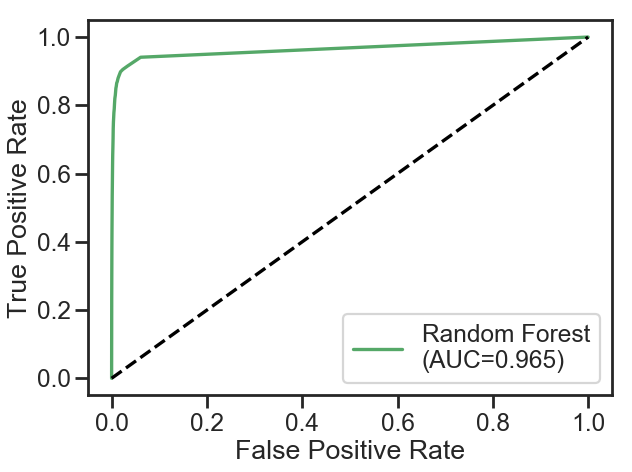

In [24]:
plt.plot([1, *false_positive_rate, 0],
         [1, *true_positive_rate, 0],
         label="Random Forest\n(AUC={:.3f})".format(roc_auc),
         color=color_RF
        )

plt.plot([0, 1], [0, 1],
         linestyle="dashed",
         color="black",
         )

# plt.xlim(left=0, right=1)
# plt.ylim(bottom=0, top=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc="best")

filename = pathlib.Path(plots_dir) / "curve_ROC"
plt.tight_layout()
plt.savefig(filename.with_suffix(".pdf"))
plt.savefig(filename.with_suffix(".png"))

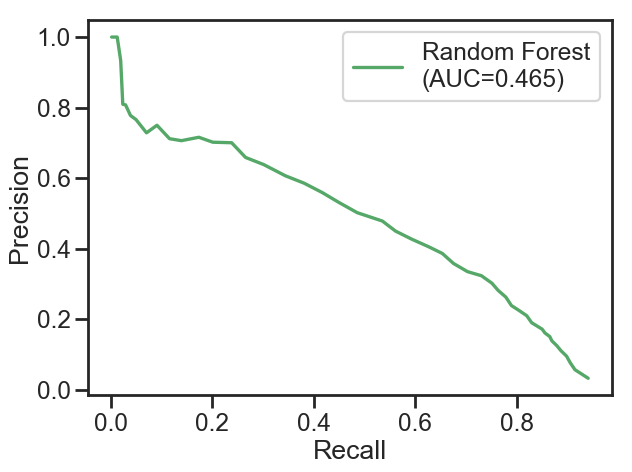

In [25]:
plt.plot(completeness, 
         purity,
         label="Random Forest\n(AUC={:.3f})".format(pr_auc),
         color=color_RF,
        )

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend(loc="best")

filename = pathlib.Path(plots_dir) / "curve_PR"
plt.tight_layout()
plt.savefig(filename.with_suffix(".pdf"))
plt.savefig(filename.with_suffix(".png"))

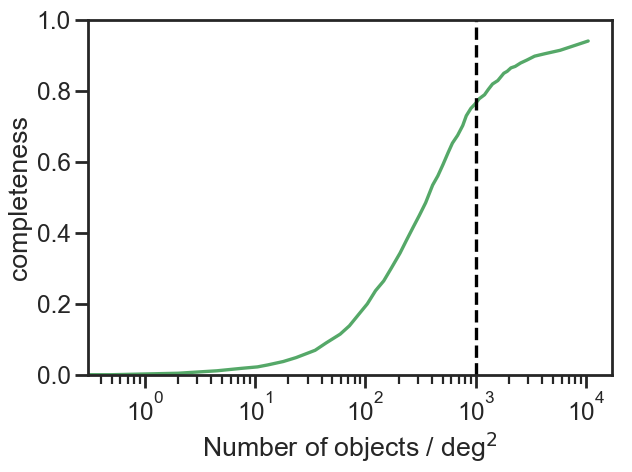

In [26]:
plt.plot(objects_per_sq_deg, completeness, color=color_RF)
plt.xlabel("Number of objects / deg$^2$")
plt.ylabel("completeness")
plt.axvline(1e3, linestyle="dashed", color="black")
plt.ylim(bottom=0, top=1)
plt.xscale("log")

filename = pathlib.Path(plots_dir) / "curve_completeness"
plt.tight_layout()
plt.savefig(filename.with_suffix(".pdf"))
plt.savefig(filename.with_suffix(".png"))

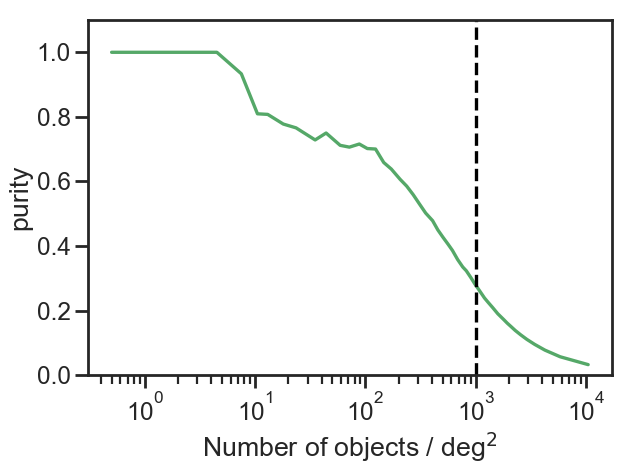

In [27]:
plt.plot(objects_per_sq_deg, purity, color=color_RF)
plt.xlabel("Number of objects / deg$^2$")
plt.ylabel("purity")
plt.axvline(1e3, linestyle="dashed", color="black")
plt.ylim(bottom=0, top=1.1)
plt.xscale("log")

filename = pathlib.Path(plots_dir) / "curve_purity"
plt.tight_layout()
plt.savefig(filename.with_suffix(".pdf"))
plt.savefig(filename.with_suffix(".png"))